In [5]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetV2B0
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
import gradio as gr

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

IMG_SIZE = (128, 128)
BATCH_SIZE = 100
NUM_CLASSES = 10
EPOCHS = 15


TensorFlow Version: 2.19.0
Keras Version: 3.10.0


In [6]:

base_dir = 'Dataset'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

train_ds = image_dataset_from_directory(train_dir, labels='inferred', label_mode='int',
                                        image_size=IMG_SIZE, interpolation='nearest',
                                        batch_size=BATCH_SIZE, shuffle=True)

val_ds = image_dataset_from_directory(validation_dir, labels='inferred', label_mode='int',
                                      image_size=IMG_SIZE, interpolation='nearest',
                                      batch_size=BATCH_SIZE, shuffle=False)

test_ds = image_dataset_from_directory(test_dir, labels='inferred', label_mode='int',
                                       image_size=IMG_SIZE, interpolation='nearest',
                                       batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names
print("Class Names:", class_names)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

def prepare_data(ds):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds_processed = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_processed = prepare_data(train_ds_processed)
val_ds_processed = prepare_data(val_ds)
test_ds_processed = prepare_data(test_ds)


Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Class Names: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [7]:

base_model = EfficientNetV2B0(include_top=False, weights='imagenet',
                              input_tensor=layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name="input_layer"))

x = base_model.output
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
x = layers.Dropout(0.2, name="dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="predictions")(x)
model = keras.Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

print("--- Training the Classification Head ---")
history_head = model.fit(train_ds_processed, epochs=5, validation_data=val_ds_processed)


--- Training the Classification Head ---
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 971ms/step - accuracy: 0.1000 - loss: 2.4590 - val_accuracy: 0.1967 - val_loss: 2.2563
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 909ms/step - accuracy: 0.1752 - loss: 2.2550 - val_accuracy: 0.3067 - val_loss: 2.0724
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 907ms/step - accuracy: 0.2759 - loss: 2.1077 - val_accuracy: 0.4533 - val_loss: 1.9014
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 915ms/step - accuracy: 0.3574 - loss: 1.9462 - val_accuracy: 0.5567 - val_loss: 1.7438
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 928ms/step - accuracy: 0.4921 - loss: 1.7900 - val_accuracy: 0.6700 - val_loss: 1.5993


In [8]:

for layer in base_model.layers:
    layer.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

print("--- Fine-tuning the Entire Model ---")
history_fine_tune = model.fit(train_ds_processed, epochs=EPOCHS,
                              validation_data=val_ds_processed, callbacks=callbacks)


--- Fine-tuning the Entire Model ---
Epoch 1/15


24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3870 - loss: 1.9011 - val_accuracy: 0.7867 - val_loss: 1.1470
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7912 - loss: 1.0742 - val_accuracy: 0.8833 - val_loss: 0.7008
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8801 - loss: 0.6440 - val_accuracy: 0.9000 - val_loss: 0.4776
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9308 - loss: 0.3973 - val_accuracy: 0.9267 - val_loss: 0.3644
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9499 - loss: 0.2510 - val_accuracy: 0.9300 - val_loss: 0.3005
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9725 - loss: 0.1762 - val_accuracy: 0.9333 - val_loss: 0.2604
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9806 - loss: 0.1249 - val_accuracy: 0.9333 - val_loss: 0.2352
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9926 - loss: 0.0780 - val_accuracy: 0.9367 - val_loss: 0.2147
Epo

In [9]:

print("--- Evaluating the Model on Test Data ---")
test_loss, test_accuracy = model.evaluate(test_ds_processed)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_probs = model.predict(test_ds_processed)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds_processed], axis=0)

print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

print("--- Confusion Matrix ---")
print(confusion_matrix(y_true, y_pred))


--- Evaluating the Model on Test Data ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - accuracy: 0.9458 - loss: 0.1725
Test Loss: 0.1486
Test Accuracy: 0.9567
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step
--- Classification Report ---
                 precision    recall  f1-score   support

        Battery       0.96      0.80      0.87        30
       Keyboard       1.00      0.97      0.98        30
      Microwave       0.88      0.97      0.92        30
         Mobile       1.00      1.00      1.00        30
          Mouse       0.97      1.00      0.98        30
            PCB       0.97      0.97      0.97        30
         Player       0.91      0.97      0.94        30
        Printer       0.97      1.00      0.98        30
     Television       1.00      0.90      0.95        30
Washing Machine       0.94      1.00      0.97        30

       accuracy                           0.96       300
      macro avg       0.96      0.96      0.96       300
   weighted avg       0.96      0

2025-07-06 14:07:43.474570: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


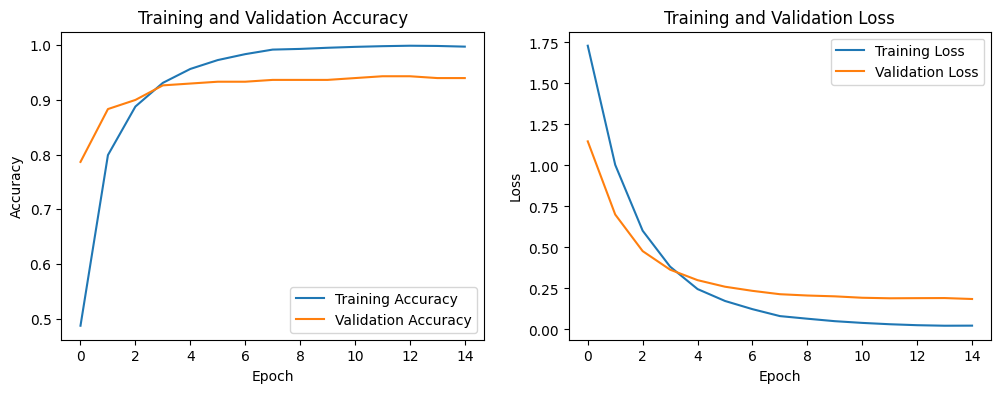

In [10]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

def classify_e_waste_image(img):
    img = tf.image.resize(tf.convert_to_tensor(img), IMG_SIZE)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)[0]
    return {class_names[i]: float(predictions[i]) for i in range(NUM_CLASSES)}

iface = gr.Interface(fn=classify_e_waste_image,
                     inputs=gr.Image(type="numpy"),
                     outputs=gr.Label(num_top_classes=3),
                     title="E-Waste Image Classifier",
                     description="Upload an image of e-waste to classify it into one of 10 categories.")
iface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
